# About this notebook

## ・ This is an ensembled result of my TabNet models and the already public LGBM models.
## ・ My TabNet training notebook is at the following site.

### https://www.kaggle.com/chumajin/optiver-realized-tabnet-baseline

## ・ In this version, the already public LGBM models are as follows(LB : 0.21075).
https://www.kaggle.com/felipefonte99/optiver-lgb-with-optimized-params Thank you for Felipe Loque. please upvote his work.


## <span style="color: red; ">from ver 12, updated tabnetmodel (just changed the k-fold method, LB :0.21408 ) and weights of emsembled models</span>

### <span style="color: red; ">**If you share this notebook with a fork, I'm glad that you edit that it is not looked like as if you wrote it all to avoid     misunderstanding.Because if you fork with little editing, it will look as if you wrote it all. Thank you.**</span>


## This is work in progress, I may change the ensemble models and other parameters depending on the situation.


--------------------------------------------------------------------------------------------------------------------------------------------------------------
## Other reference

The features used are the same as the LGBM notebook below. Thank you for ragnar and A.sato. please upvote his work.

https://www.kaggle.com/ragnar123/optiver-realized-volatility-lgbm-baseline

https://www.kaggle.com/tommy1028/lightgbm-starter-with-feature-engineering-idea

I respect them. please upvote their great work.

---------------------------------------------------------

# 0. Preparation

In [ ]:
import os
import glob
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import scipy as sc
from sklearn.model_selection import KFold
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 300)
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

import random

In [ ]:
SEED = 42

def random_seed(SEED):
    
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

random_seed(SEED)

## 0.1 Load train data : 

I just folk, save and making dataset from public notebooks. This is origined by
* https://www.kaggle.com/ragnar123/optiver-realized-volatility-lgbm-baseline 
* https://www.kaggle.com/tommy1028/lightgbm-starter-with-feature-engineering-idea
 
Thank you very much.

If you want to see feature engineering, please refer his work (this is very clean code.)

In [ ]:
train = pd.read_pickle("../input/optiverlgbbase/train.pkl")
train

## 0.2 Fillna

In [ ]:
for col in train.columns.to_list()[4:]:
    train[col] = train[col].fillna(train[col].mean())

## 0.3 Making Standardscaler for Normalization

In [ ]:
scales = train.drop(['row_id', 'target', 'time_id',"stock_id"], axis = 1).columns.to_list()

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train[scales])

In [ ]:
import pickle

scaler_name = "scaler"

# saving model
pickle.dump(scaler, open(scaler_name, 'wb'))

## 0.4 : Label Encoder 
maybe stock id shoud be sequencial value when using categorical features.

In [ ]:
from sklearn.preprocessing import LabelEncoder 
import pickle

In [ ]:
le=LabelEncoder()
le.fit(train["stock_id"])
train["stock_id"] = le.transform(train["stock_id"])

with open( 'stock_id_encoder.txt', 'wb') as f:
    pickle.dump(le, f)

In [ ]:
train["stock_id"]

## 0.5 Kfold
reffered by https://www.kaggle.com/abhishek/step-1-create-folds 


this is just I like it.

In [ ]:
from sklearn import datasets
from sklearn import model_selection

def create_folds(data, num_splits,target):
    # we create a new column called kfold and fill it with -1
    data["kfold"] = -1
    
    # the next step is to randomize the rows of the data
    data = data.sample(frac=1).reset_index(drop=True)

    # calculate number of bins by Sturge's rule
    # I take the floor of the value, you can also
    # just round it
    num_bins = int(np.floor(1 + np.log2(len(data))))
    
    # bin targets
    data.loc[:, "bins"] = pd.cut(
        data[target], bins=num_bins, labels=False
    )
    
    # initiate the kfold class from model_selection module
    kf = model_selection.StratifiedKFold(n_splits=num_splits)
    
    # fill the new kfold column
    # note that, instead of targets, we use bins!
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)):
        data.loc[v_, 'kfold'] = f
    
    # drop the bins column
    data = data.drop("bins", axis=1)

    # return dataframe with folds
    return data

train = create_folds(train, 5,"target")

# 1. TabNet

In [ ]:
!pip install ../input/pytorchtabnet/pytorch_tabnet-3.1.1-py3-none-any.whl

In [ ]:
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.metrics import Metric
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
from pathlib import Path

This metric is from https://www.kaggle.com/atamazian/optiver-tabnet-training
Thank you and please upvote his work.

In [ ]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    
    if (y_true == 0).any():
        raise ValueError("Root Mean Square Percentage Error cannot be used when "
                         "targets contain zero values.")
        
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0)).item()

    return loss

In [ ]:
class RMSPE(Metric):
    def __init__(self):
        self._name = "rmspe"
        self._maximize = False

    def __call__(self, y_true, y_score):
        return rmspe(y_true, y_score)

In [ ]:
tabnet_params = dict(
    n_d = 32,
    n_a = 32,
    n_steps = 3,
    gamma = 1.3,
    lambda_sparse = 0,
    optimizer_fn = optim.Adam,
    optimizer_params = dict(lr = 1e-2, weight_decay = 1e-5),
    mask_type = "entmax",
    scheduler_params = dict(
        mode = "min", patience = 5, min_lr = 1e-5, factor = 0.9),
    scheduler_fn = ReduceLROnPlateau,
    seed = 42,
    #verbose = 5,
    cat_dims=[len(le.classes_)], cat_emb_dim=[10], cat_idxs=[-1] # define categorical features
)

In [ ]:
# tabnet model

clf = TabNetRegressor(**tabnet_params)

# 2. Inference
# 2.1 TabNet

In [ ]:
# data directory
data_dir = '../input/optiver-realized-volatility-prediction/'

# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# Function to calculate the log of the return
# Remember that logb(x / y) = logb(x) - logb(y)
def log_return(series):
    return np.log(series).diff()

# Calculate the realized volatility
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))

# Function to read our base train and test set
def read_train_test():
    train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'Our training set has {train.shape[0]} rows')
    return train, test

# Function to preprocess book data (for each stock id)
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    # Dict for aggregations
    create_feature_dict = {
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        'total_volume':[np.sum, np.mean, np.std],
        'volume_imbalance':[np.sum, np.mean, np.std]
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_feature_450 = get_stats_window(seconds_in_bucket = 450, add_suffix = True)
    df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
    df_feature_150 = get_stats_window(seconds_in_bucket = 150, add_suffix = True)
    
    # Merge all
    df_feature = df_feature.merge(df_feature_450, how = 'left', left_on = 'time_id_', right_on = 'time_id__450')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_150, how = 'left', left_on = 'time_id_', right_on = 'time_id__150')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__450', 'time_id__300', 'time_id__150'], axis = 1, inplace = True)
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.mean],
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_feature_450 = get_stats_window(seconds_in_bucket = 450, add_suffix = True)
    df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
    df_feature_150 = get_stats_window(seconds_in_bucket = 150, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_450, how = 'left', left_on = 'time_id_', right_on = 'time_id__450')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_150, how = 'left', left_on = 'time_id_', right_on = 'time_id__150')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__450', 'time_id__300', 'time_id__150'], axis = 1, inplace = True)
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    # Get realized volatility columns
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_450', 'log_return2_realized_volatility_450', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_150', 'log_return2_realized_volatility_150', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_450', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_150']

    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df
    
# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    return df

# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate(train, test):
    # Hyperparammeters (just basic)
    params = {
      'objective': 'rmse',  
      'boosting_type': 'gbdt',
      'num_leaves': 100,
      'n_jobs': -1,
      'learning_rate': 0.1,
      'feature_fraction': 0.8,
      'bagging_fraction': 0.8,
      'verbose': -1
    }
    
    # Split features and target
    x = train.drop(['row_id', 'target', 'time_id'], axis = 1)
    y = train['target']
    x_test = test.drop(['row_id', 'time_id'], axis = 1)
    # Transform stock id to a numeric value
    x['stock_id'] = x['stock_id'].astype(int)
    x_test['stock_id'] = x_test['stock_id'].astype(int)
    
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(x_test.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = 5, random_state = 66, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(x)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights, categorical_feature = ['stock_id'])
        val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights, categorical_feature = ['stock_id'])
        model = lgb.train(params = params, 
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          num_boost_round = 10000, 
                          early_stopping_rounds = 50, 
                          verbose_eval = 50,
                          feval = feval_rmspe)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val)
        # Predict the test set
        test_predictions += model.predict(x_test) / 5
        
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    # Return test predictions
    return test_predictions


tabnet model load is written on this discussion
https://www.kaggle.com/c/lish-moa/discussion/196625

In [ ]:
path = "../input/optivertabnetmodels-v2"

for fold in range(5):
    !cp -r ../input/optivertabnetmodels-v2/tabnet_model_test_{str(fold)}/* .
    !zip tabnet_model_test_{str(fold)}.zip model_params.json network.pt



In [ ]:
modelpath = [os.path.join("./",s) for s in os.listdir("./") if ("zip" in s)]
modelpath

In [ ]:
# Read train and test
train2, test = read_train_test()

# Get unique stock ids 
#train_stock_ids = train['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
#train_ = preprocessor(train_stock_ids, is_train = True)
#train = train.merge(train_, on = ['row_id'], how = 'left')

# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')

# Get group stats of time_id and stock_id
#train = get_time_stock(train)
test = get_time_stock(test)

#train.to_pickle("train.pkl")

# Traing and evaluate
#test_predictions = train_and_evaluate(train, test)


## fillna for test data ##

train=train.drop("kfold",axis=1)
        
for col in train.columns.to_list()[4:]:
    test[col] = test[col].fillna(train[col].mean())


### normarize ###    

x_test = test.drop(['row_id', 'time_id',"stock_id"], axis = 1).values
    # Transform stock id to a numeric value

x_test = scaler.transform(x_test)
X_testdf = pd.DataFrame(x_test)

X_testdf["stock_id"]=test["stock_id"]

# Label encoding
X_testdf["stock_id"] = le.transform(X_testdf["stock_id"])




x_test = X_testdf.values
    
    
preds=[]
for path in modelpath:
    
    clf.load_model(path)
    preds.append(clf.predict(x_test).squeeze(-1))
    
preds = np.mean(preds,axis=0)


#test['target'] = preds
#test[['row_id', 'target']].to_csv('submission.csv',index = False)


# 2.2 LGBM

In [ ]:
path2 = "../input/optiverlgbbase"


target_models2 = [pickle.load(open(os.path.join(path2,s), 'rb')) for s in os.listdir(path2) if (".bin" in s)]

In [ ]:
# Read train and test
train, test = read_train_test()

# Get unique stock ids 
#train_stock_ids = train['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
#train_ = preprocessor(train_stock_ids, is_train = True)
#train = train.merge(train_, on = ['row_id'], how = 'left')

# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')

# Get group stats of time_id and stock_id
#train = get_time_stock(train)
test = get_time_stock(test)

#train.to_pickle("train.pkl")

# Traing and evaluate
#test_predictions = train_and_evaluate(train, test)
# Save test predictions
#################            
        ### model A #####
        #################


x_test = test.drop(['row_id', 'time_id'], axis = 1)

#x_test["stock_id"] = le.transform(x_test["stock_id"])
    # Transform stock id to a numeric value
x_test['stock_id'] = x_test['stock_id'].astype(int)

preds2=[]
for model in target_models2:
    preds2.append(model.predict(x_test))
preds2 = np.mean(preds2,axis=0)



# 2.3 Merge

#### Submission results:

* 0.5 × tabnet + 0.5 × LGBM = 0.20879
* 0.4 × tabnet + 0.6 × LGBM = 0.20860
* 0.3 × tabnet + 0.7 × LGBM = 0.20870

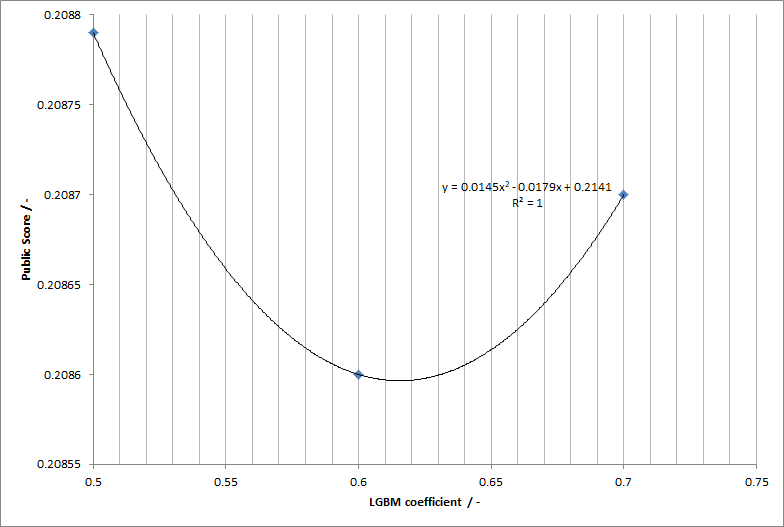

The optimum coefficient was easily calculated from the approximation of the quadratic curve. (min value is when it is the 0.617)


But this is temporary score(just for performance of emsemble TabNet 0.21408 × LGBM 0.21075 ). There is still a month before submitting.

In [ ]:
#finpreds = np.mean([preds,preds2],axis=0)

finpreds = (1-0.617) * preds + 0.617 * preds2


test['target'] = finpreds
test[['row_id', 'target']].to_csv('submission.csv',index = False)

In [ ]:
test[['row_id', 'target']]

# This is work in progress. I hope it is helpful for you. Thank you !